# Wide-field imaging demonstration

This script makes a fake data set, fills it with a number of point components, and then images it using a variety of algorithms. See imaging-fits for a similar notebook that checks for errors in the recovered properties of the images.

The measurement equation for a wide field of view interferometer is:

$$V(u,v,w) =\int \frac{I(l,m)}{\sqrt{1-l^2-m^2}} e^{-2 \pi j (ul+um + w(\sqrt{1-l^2-m^2}-1))} dl dm$$

We will show various algorithms for computing approximations to this integral. Calculation of the visibility V from the sky brightness I is called predict, and the inverse is called invert.

In [1]:
%matplotlib inline

import os
import sys

results_dir = '/tmp/'

from matplotlib import pylab

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from rascil.data_models.polarisation import PolarisationFrame

from rascil.processing_components.image import create_w_term_like

from rascil.processing_components import  create_visibility, create_visibility_from_rows, create_skycomponent,\
    show_image, export_image_to_fits, create_named_configuration, create_image_from_visibility, \
    dft_skycomponent_visibility, advise_wide_field, vis_timeslice_iter, weight_visibility, vis_timeslices, \
    create_awterm_convolutionfunction, copy_visibility

# Use rsexecute for imaging
from rascil.workflows.rsexecute.execution_support.rsexecute import rsexecute

from rascil.workflows import invert_list_rsexecute_workflow

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))
mpl_logger = logging.getLogger("matplotlib") 
mpl_logger.setLevel(logging.WARNING) 

doplot = True


In [2]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

Set up rsexecute to use dask. If we are running in docker then the scheduler may be available by name.
Otherwise we just create a LocalCluster.

In [3]:
from dask.distributed import Client, LocalCluster
try:
    client = Client('tcp://scheduler:8786', timeout=10)
    print("Using docker-based Dask scheduler")
except OSError:
    client =Client(LocalCluster())
    print("Using Dask LocalCluster")
print(client)

rsexecute.set_client(client=client)

Using selector: KqueueSelector
Using selector: KqueueSelector
Using selector: KqueueSelector
Using selector: KqueueSelector
Using Dask LocalCluster
<Client: 'tcp://127.0.0.1:63795' processes=4 threads=16, memory=68.72 GB>


Construct the SKA1-LOW core configuration

In [4]:
lowcore = create_named_configuration('LOWBD2-CORE')

create_named_configuration: LOWBD2-CORE
	(<Quantity -2565018.31203579 m>, <Quantity 5085711.90373391 m>, <Quantity -2861033.10788063 m>)
	GeodeticLocation(lon=<Longitude 116.76444824 deg>, lat=<Latitude -26.82472208 deg>, height=<Quantity 300. m>)
create_configuration_from_file: 166 antennas/stations


We create the visibility. 

This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [5]:
times = numpy.array([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]) * (numpy.pi / 12.0)
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e7])


reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame("stokesI"))

create_visibility: 95865 rows, 0.011 GB
create_visibility: flagged 0/95865 visibilities below elevation limit 0.261799 (rad)


Advise on wide field parameters. This returns a dictionary with all the input and calculated variables.

In [6]:
advice = advise_wide_field(vt, wprojection_planes=1)

advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Minimum wavelength 2.998 (meters)
advise_wide_field: Maximum baseline 262.6 (wavelengths)
advise_wide_field: Maximum w 169.4 (wavelengths)
advise_wide_field: Station/dish diameter 35.0 (meters)
advise_wide_field: Primary beam 0.0857 (rad) 4.91 (deg) 1.77e+04 (asec)
advise_wide_field: Image field of view 0.514 (rad) 29.4 (deg) 1.06e+05 (asec)
advise_wide_field: Synthesized beam 0.00381 (rad) 0.218 (deg) 785 (asec)
advise_wide_field: Cellsize 0.00127 (rad) 0.0727 (deg) 262 (asec)
advice_wide_field: Npixels per side = 405
advice_wide_field: Npixels (power of 2) per side = 512
advice_wide_field: Npixels (power of 2, 3) per side = 512
advice_wide_field: Npixels (power of 2, 3, 4, 5) per side = 512
advice_wide_field: W sampling for full image = 0.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 8.7 (wavelengths)
advice_wide_field: Time sampling for full image = 640.1 (s)
advice_wide_field: Time sampling f

Plot the synthesized UV coverage.

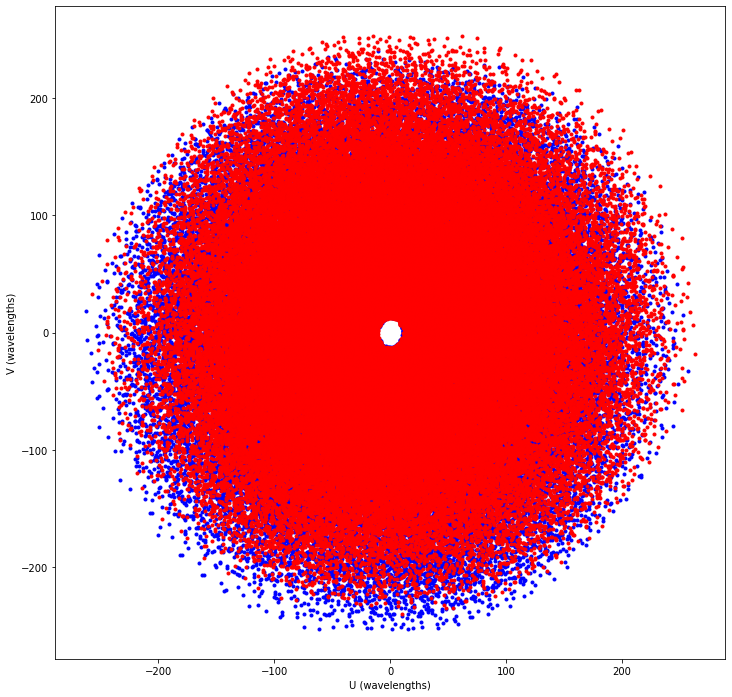

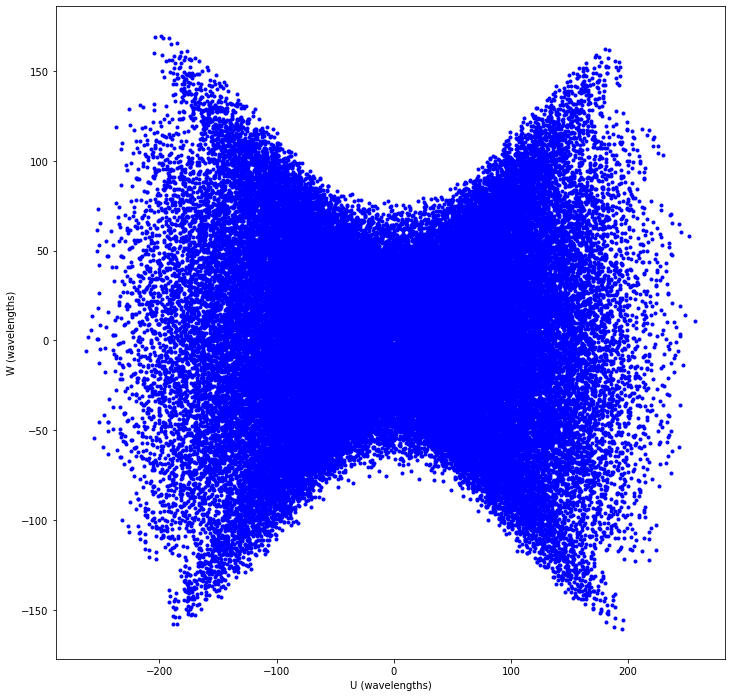

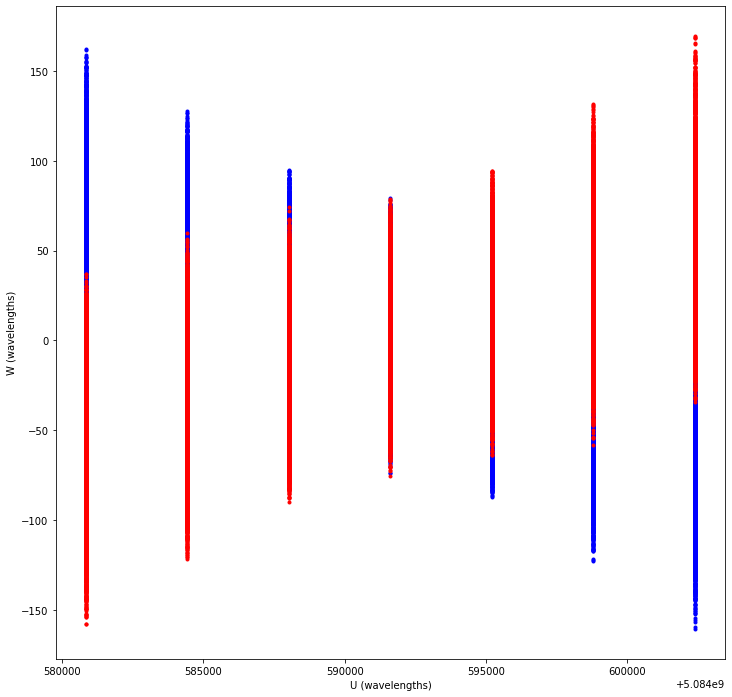

In [7]:
if doplot:
    plt.clf()
    plt.plot(vt.data['uvw'][:, 0], vt.data['uvw'][:, 1], '.', color='b')
    plt.plot(-vt.data['uvw'][:, 0], -vt.data['uvw'][:, 1], '.', color='r')
    plt.xlabel('U (wavelengths)')
    plt.ylabel('V (wavelengths)')
    plt.show()
    
    plt.clf()
    plt.plot(vt.data['uvw'][:, 0], vt.data['uvw'][:, 2], '.', color='b')
    plt.xlabel('U (wavelengths)')
    plt.ylabel('W (wavelengths)')
    plt.show()

    plt.clf()
    plt.plot(vt.data['time'][vt.u>0.0], vt.data['uvw'][:, 2][vt.u>0.0], '.', color='b')
    plt.plot(vt.data['time'][vt.u<=0.0], vt.data['uvw'][:, 2][vt.u<=0.0], '.', color='r')
    plt.xlabel('U (wavelengths)')
    plt.ylabel('W (wavelengths)')
    plt.show()

Show the planar nature of the uvw sampling, rotating with hour angle

Create a grid of components and predict each in turn, using the full phase term including w.

In [8]:
npixel = 512
cellsize=0.001
facets = 4
flux = numpy.array([[100.0]])
vt.data['vis'] *= 0.0

model = create_image_from_visibility(vt, npixel=512, cellsize=0.001, npol=1)
spacing_pixels = npixel // facets
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = 180.0 * cellsize * spacing_pixels / numpy.pi
centers = -1.5, -0.5, +0.5, +1.5
comps=list()
for iy in centers:
    for ix in centers:
        pra =  int(round(npixel // 2 + ix * spacing_pixels - 1))
        pdec = int(round(npixel // 2 + iy * spacing_pixels - 1))
        sc = pixel_to_skycoord(pra, pdec, model.wcs)
        log.info("Component at (%f, %f) %s" % (pra, pdec, str(sc)))
        comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc, 
                                   polarisation_frame=PolarisationFrame("stokesI"))
        comps.append(comp)
vt = dft_skycomponent_visibility(vt, comps)

vt_original = copy_visibility(vt)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001 radians, 0.0572958 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]
Spacing in pixels = 128
Component at (63.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    (34.54072794, -54.75874632)>
Component at (191.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    (21.67016023, -55.97155392)>
Component at (319.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    (8.53437599, -55.98101975)>
Component at (447.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    (355.65593443, -54.78677607)>
Component a

Make the dirty image and point spread function using the two-dimensional approximation:

$$V(u,v,w) =\int I(l,m) e^{2 \pi j (ul+um)} dl dm$$

Note that the shape of the sources vary with position in the image. This space-variant property of the PSF arises from the w-term neglected in the two-dimensional invert.

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001 radians, 0.0572958 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]


/Users/timcornwell/opt/anaconda3/envs/rascil_env/lib/python3.7/site-packages/distributed/worker.py:3349: UserWarning: Large object of size 2.10 MB detected in task graph: 
  ('getitem-76bcd569e547926b854ba33476d78648', <rasc ... -180a2116d8c1')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


Max, min in dirty image = 49.220748, -8.719588, sumwt = 31701.000000


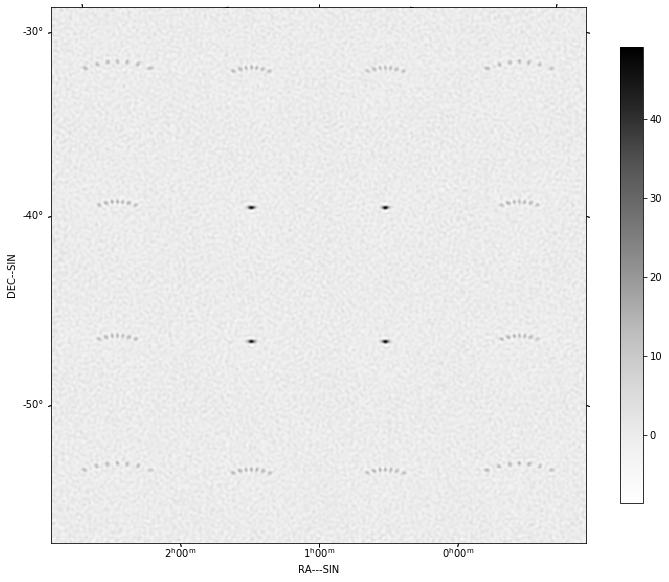

In [9]:
dirty = create_image_from_visibility(vt, npixel=512, cellsize=0.001, 
                                     polarisation_frame=PolarisationFrame("stokesI"))
vt = weight_visibility(vt, dirty)
vt_original = copy_visibility(vt)
future = invert_list_rsexecute_workflow([vt], [dirty], context='2d')
dirty, sumwt = rsexecute.compute(future, sync=True)[0]

if doplot:
    show_image(dirty)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirty.data.max(), dirty.data.min(), sumwt))

export_image_to_fits(dirty, '%s/imaging-wterm_dirty.fits' % (results_dir))

This occurs because the Fourier transform relationship between sky brightness and visibility is only accurate over small fields of view. 

Hence we can make an accurate image by partitioning the image plane into small regions, treating each separately and then glueing the resulting partitions into one image. We call this image plane partitioning image plane faceting.

$$V(u,v,w) = \sum_{i,j} \frac{1}{\sqrt{1- l_{i,j}^2- m_{i,j}^2}} e^{-2 \pi j (ul_{i,j}+um_{i,j} + w(\sqrt{1-l_{i,j}^2-m_{i,j}^2}-1))}
\int  I(\Delta l, \Delta m) e^{-2 \pi j (u\Delta l_{i,j}+u \Delta m_{i,j})} dl dm$$


create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001 radians, 0.0572958 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]
Max, min in dirty image = 102.477593, -11.772359, sumwt = 507216.000000


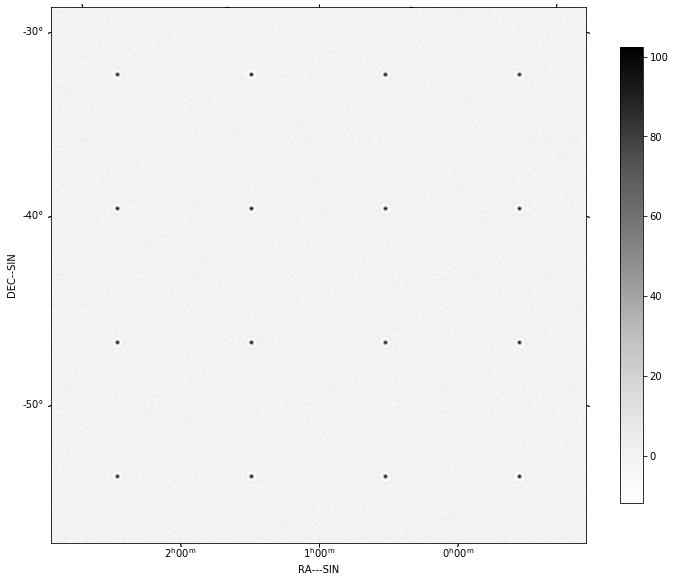

In [10]:
vt = copy_visibility(vt_original)

dirtyFacet = create_image_from_visibility(vt, npixel=512, cellsize=0.001, npol=1)
future = invert_list_rsexecute_workflow([vt], [dirtyFacet], facets=4, context='facets')
dirtyFacet, sumwt = rsexecute.compute(future, sync=True)[0]

if doplot:
    show_image(dirtyFacet)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirtyFacet.data.max(), dirtyFacet.data.min(), sumwt))
export_image_to_fits(dirtyFacet, '%s/imaging-wterm_dirtyFacet.fits' % (results_dir))

That was the best case. This time, we will not arrange for the partitions to be centred on the sources. 

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001 radians, 0.0572958 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]
Max, min in dirty image = 51.663404, -9.843857, sumwt = 126804.000000


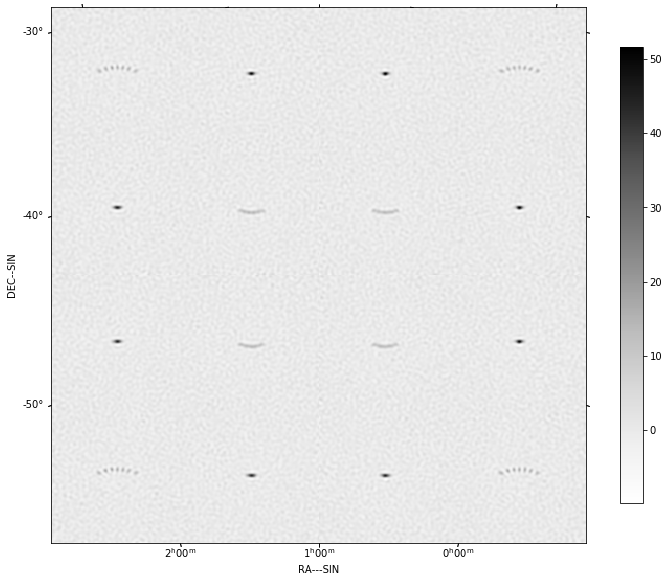

In [11]:
vt = copy_visibility(vt_original)

dirtyFacet2 = create_image_from_visibility(vt, npixel=512, cellsize=0.001, npol=1)
future = invert_list_rsexecute_workflow([vt], [dirtyFacet2], facets=2, context='facets')
dirtyFacet2, sumwt = rsexecute.compute(future, sync=True)[0]


if doplot:
    show_image(dirtyFacet2)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirtyFacet2.data.max(), dirtyFacet2.data.min(), sumwt))
export_image_to_fits(dirtyFacet2, '%s/imaging-wterm_dirtyFacet2.fits' % (results_dir))

Another approach is to partition the visibility data by slices in w. The measurement equation is approximated as:

$$V(u,v,w) =\sum_i \int   \frac{ I(l,m) e^{-2 \pi j (w_i(\sqrt{1-l^2-m^2}-1))})}{\sqrt{1-l^2-m^2}} e^{-2 \pi j (ul+um)} dl dm$$

If images constructed from slices in w are added after applying a w-dependent image plane correction, the w term will be corrected. 

The w-dependent w-beam is:

create_w_term_image: For w = 169.4, field of view = 0.512000, Fresnel number = 11.10


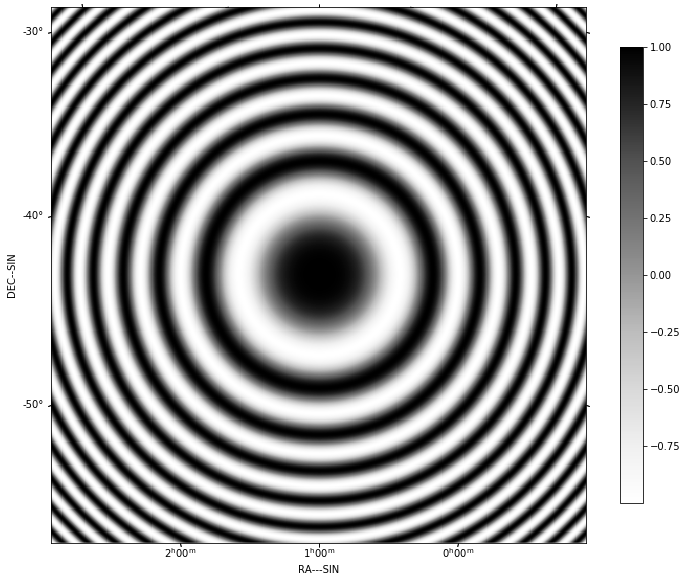

In [12]:
if doplot:
    wterm = create_w_term_like(model, phasecentre=vt.phasecentre, w=numpy.max(vt.w))
    show_image(wterm)
    plt.show()

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001 radians, 0.0572958 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]


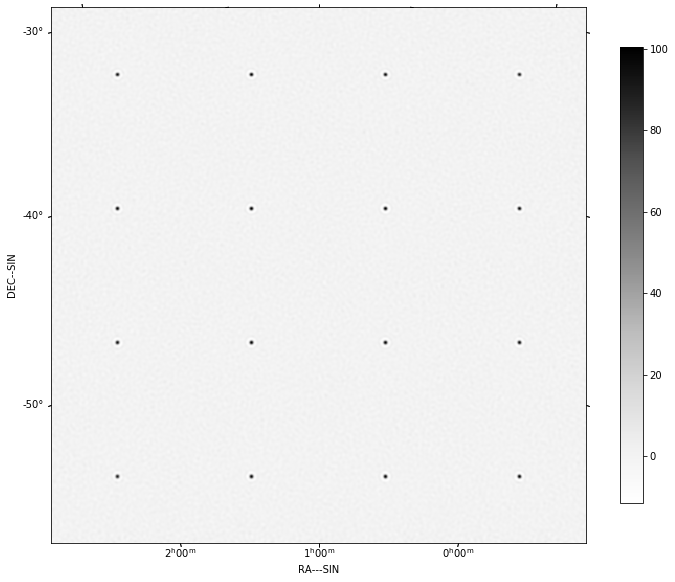

Max, min in dirty image = 100.483442, -11.544620, sumwt = 31701.000000


In [13]:
vt = copy_visibility(vt_original)

dirtywstack = create_image_from_visibility(vt, npixel=512, cellsize=0.001, npol=1)
future = invert_list_rsexecute_workflow([vt], [dirtywstack], vis_slices=101, context='wstack')
dirtywstack, sumwt = rsexecute.compute(future, sync=True)[0]

show_image(dirtywstack)
plt.show()

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % 
      (dirtywstack.data.max(), dirtywstack.data.min(), sumwt))

export_image_to_fits(dirtywstack, '%s/imaging-wterm_dirty_wstack.fits' % (results_dir))

The w-term can also be viewed as a time-variable distortion. Approximating the array as instantaneously co-planar, we have that w can be expressed in terms of $u,v$

$$w = a u + b v$$

Transforming to a new coordinate system:

$$ l' = l + a (\sqrt{1-l^2-m^2}-1))$$
$$ m' = m + b (\sqrt{1-l^2-m^2}-1))$$

Ignoring changes in the normalisation term, we have:

$$V(u,v,w) =\int \frac{I(l',m')}{\sqrt{1-l'^2-m'^2}} e^{-2 \pi j (ul'+um')} dl' dm'$$

To illustrate this, we will construct images as a function of time. For comparison, we show difference of each time slice from the best facet image. Instantaneously the sources are un-distorted but do lie in the wrong location.

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 193.168337 wavelengths
create_image_from_visibility: Critical cellsize = 0.002588 radians, 0.148305 degrees
create_image_from_visibility: Cellsize          = 0.001 radians, 0.0572958 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]
Max, min in dirty image = 95.641822, -16.727650, sumwt = 4216.610661


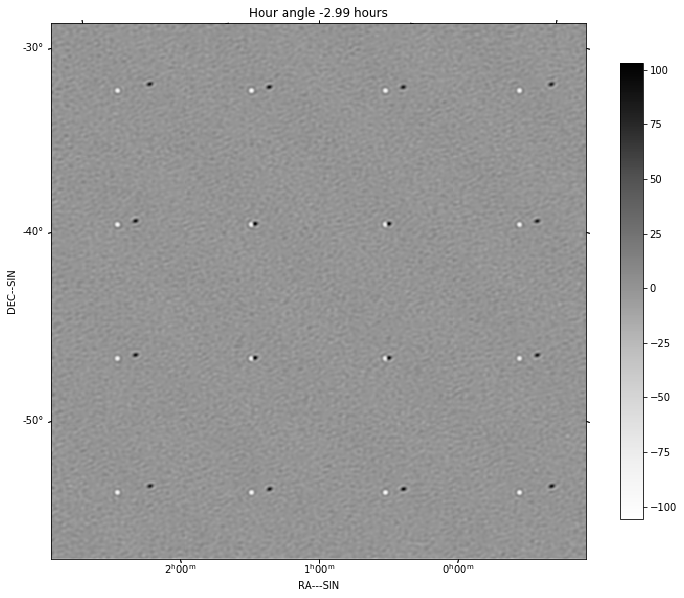

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 231.753249 wavelengths
create_image_from_visibility: Critical cellsize = 0.002157 radians, 0.123614 degrees
create_image_from_visibility: Cellsize          = 0.001 radians, 0.0572958 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]
Max, min in dirty image = 100.519607, -17.807714, sumwt = 4508.422216


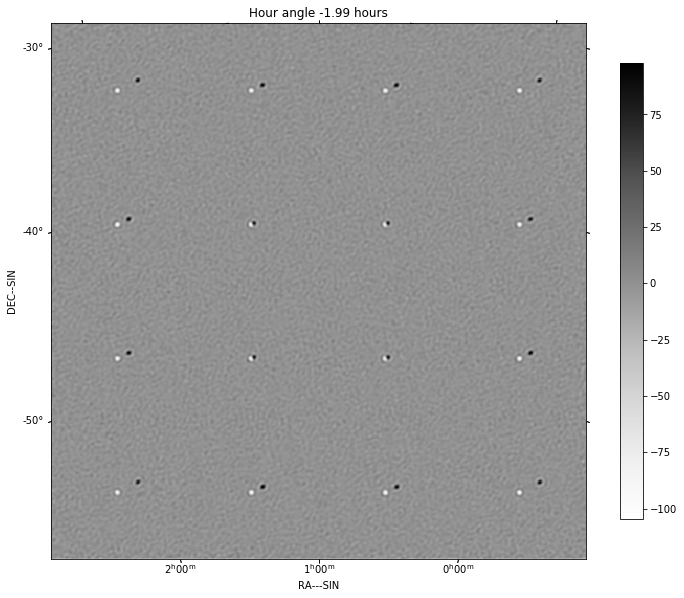

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 255.914039 wavelengths
create_image_from_visibility: Critical cellsize = 0.001954 radians, 0.111943 degrees
create_image_from_visibility: Cellsize          = 0.001 radians, 0.0572958 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]
Max, min in dirty image = 99.690697, -17.608646, sumwt = 4735.435580


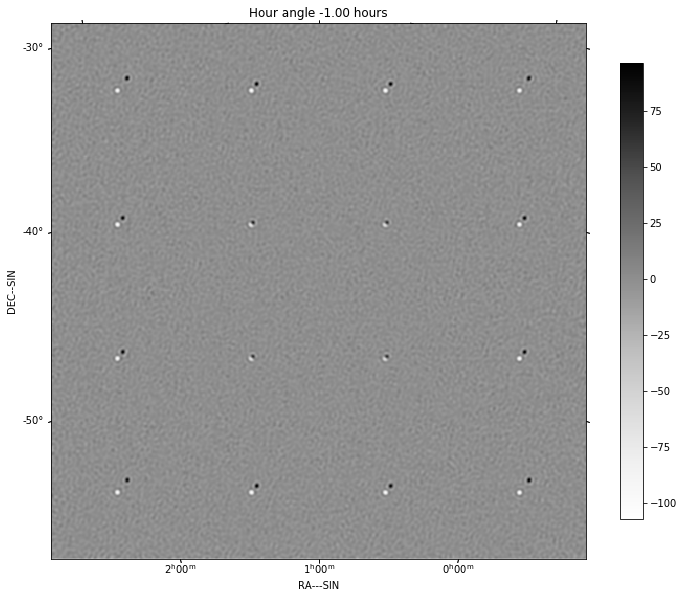

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001 radians, 0.0572958 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]
Max, min in dirty image = 102.909868, -19.624505, sumwt = 4806.769444


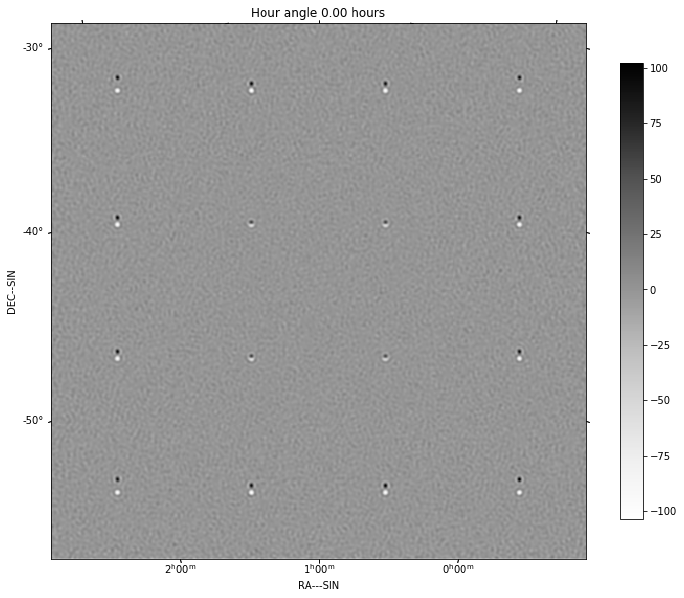

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 253.664251 wavelengths
create_image_from_visibility: Critical cellsize = 0.001971 radians, 0.112936 degrees
create_image_from_visibility: Cellsize          = 0.001 radians, 0.0572958 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]
Max, min in dirty image = 101.931847, -18.677038, sumwt = 4732.772801


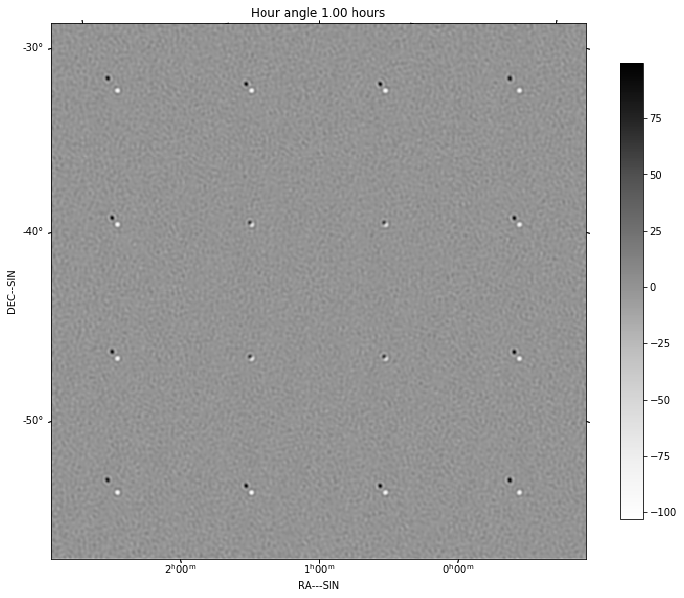

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 236.819632 wavelengths
create_image_from_visibility: Critical cellsize = 0.002111 radians, 0.120969 degrees
create_image_from_visibility: Cellsize          = 0.001 radians, 0.0572958 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]
Max, min in dirty image = 102.692951, -18.823002, sumwt = 4524.935947


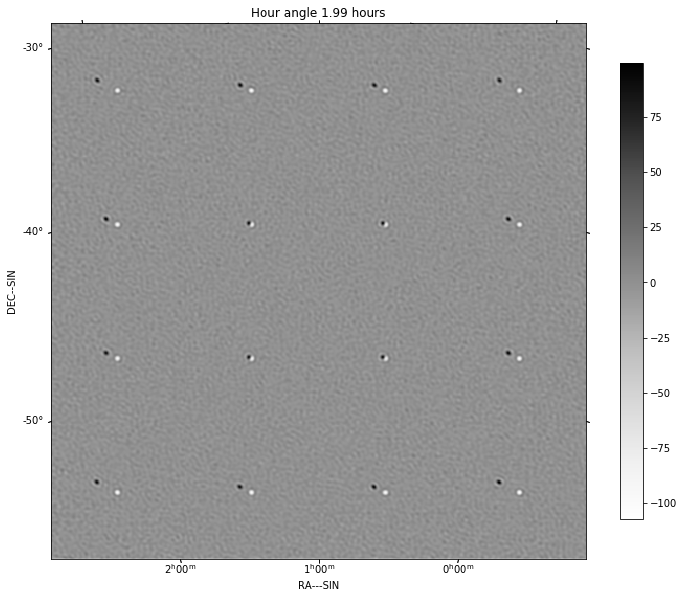

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 204.762355 wavelengths
create_image_from_visibility: Critical cellsize = 0.002442 radians, 0.139908 degrees
create_image_from_visibility: Cellsize          = 0.001 radians, 0.0572958 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]
Max, min in dirty image = 98.916621, -17.862308, sumwt = 4176.053350


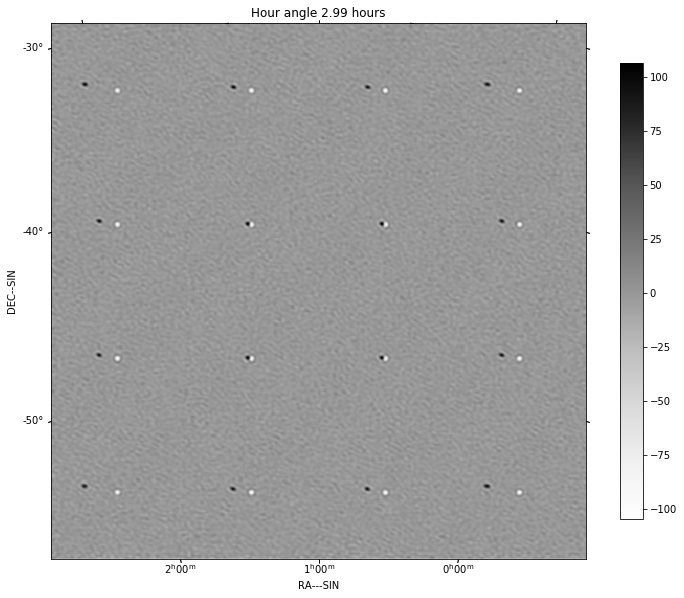

In [14]:
vt = copy_visibility(vt_original)

t_ha0 = numpy.average(vt.time)

for rows in vis_timeslice_iter(vt):
    visslice = create_visibility_from_rows(vt, rows)
    dirtySnapshot = create_image_from_visibility(visslice, npixel=512, cellsize=0.001, npol=1, compress_factor=0.0)
    future = invert_list_rsexecute_workflow([visslice], [dirtySnapshot], context='2d')
    dirtySnapshot, sumwt = rsexecute.compute(future, sync=True)[0]
    
    print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % 
          (dirtySnapshot.data.max(), dirtySnapshot.data.min(), sumwt))
    if doplot:
        dirtySnapshot.data -= dirtyFacet.data
        show_image(dirtySnapshot)
        plt.title("Hour angle %.2f hours" % ((numpy.average(visslice.time) - t_ha0) * 12.0 / 43200.0))
        plt.show()

This timeslice imaging leads to a straightforward algorithm in which we correct each time slice and then sum the resulting timeslices. 

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001 radians, 0.0572958 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]


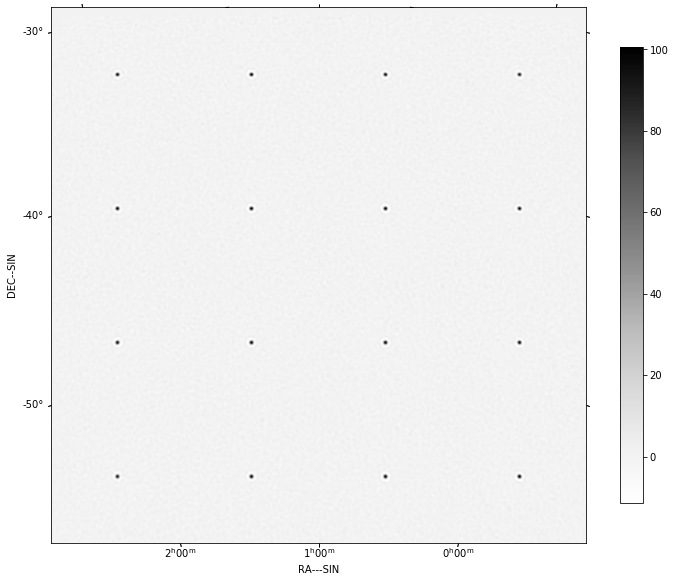

Max, min in dirty image = 100.684940, -11.477320, sumwt = 31701.000000


In [15]:
vt = copy_visibility(vt_original)

dirtyTimeslice = create_image_from_visibility(vt, npixel=512, cellsize=0.001, npol=1)
future = invert_list_rsexecute_workflow([vt], [dirtyTimeslice], vis_slices=vis_timeslices(vt, 'auto'),
                                       padding=2, context='timeslice')
dirtyTimeslice, sumwt = rsexecute.compute(future, sync=True)[0]


show_image(dirtyTimeslice)
plt.show()

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % 
      (dirtyTimeslice.data.max(), dirtyTimeslice.data.min(), sumwt))

export_image_to_fits(dirtyTimeslice, '%s/imaging-wterm_dirty_Timeslice.fits' % (results_dir))

Next we try w-projection. For a fixed w, the measurement equation can be stated as as a convolution in Fourier space.

$$V(u,v,w) =G_w(u,v) \ast \int \frac{I(l,m)}{\sqrt{1-l^2-m^2}} e^{-2 \pi j (ul+um)} dl dm$$

where the convolution function is:

$$G_w(u,v) = \int \frac{1}{\sqrt{1-l^2-m^2}} e^{-2 \pi j (ul+um + w(\sqrt{1-l^2-m^2}-1))} dl dm$$


Hence when gridding, we can use the transform of the w beam to correct this effect while gridding. 

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001 radians, 0.0572958 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]
create_w_term_image: For w = -396.0, field of view = 0.512000, Fresnel number = 25.95
create_w_term_image: For w = -388.1, field of view = 0.512000, Fresnel number = 25.44
create_w_term_image: For w = -380.2, field of view = 0.512000, Fresnel number = 24.92
create_w_term_image: For w = -372.3, field of view = 0.512000, Fresnel number = 24.40
create_w_term_image: For w = -364.4, field of view = 0.512000, Fresnel number = 23.88
create_w_term_image: For

create_w_term_image: For w = 324.8, field of view = 0.512000, Fresnel number = 21.28
create_w_term_image: For w = 332.7, field of view = 0.512000, Fresnel number = 21.80
create_w_term_image: For w = 340.6, field of view = 0.512000, Fresnel number = 22.32
create_w_term_image: For w = 348.5, field of view = 0.512000, Fresnel number = 22.84
create_w_term_image: For w = 356.4, field of view = 0.512000, Fresnel number = 23.36
create_w_term_image: For w = 364.4, field of view = 0.512000, Fresnel number = 23.88
create_w_term_image: For w = 372.3, field of view = 0.512000, Fresnel number = 24.40
create_w_term_image: For w = 380.2, field of view = 0.512000, Fresnel number = 24.92
create_w_term_image: For w = 388.1, field of view = 0.512000, Fresnel number = 25.44
create_w_term_image: For w = 396.0, field of view = 0.512000, Fresnel number = 25.95
Max, min in dirty image = 100.225951, -11.016452, sumwt = 31701.000000


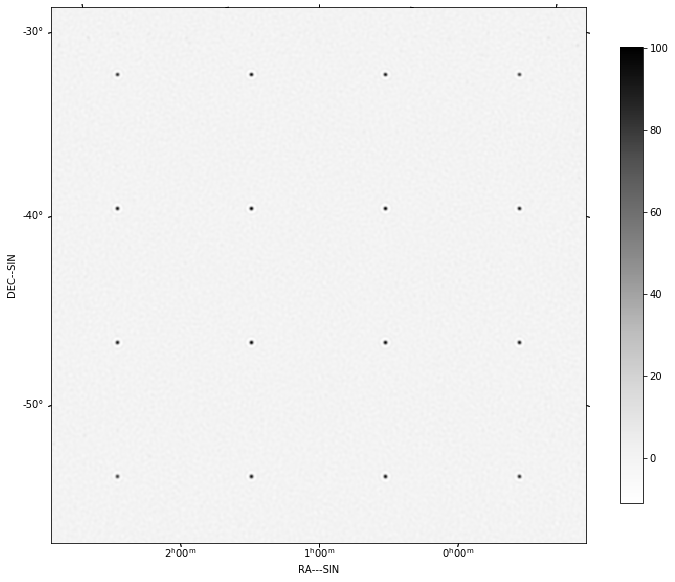

In [16]:
vt = copy_visibility(vt_original)

dirtyWProjection = create_image_from_visibility(vt, npixel=512, cellsize=0.001, npol=1)

gcfcf = create_awterm_convolutionfunction(model, nw=101, wstep=800.0/101, oversampling=8, 
                                                    support=60,
                                                    use_aaf=True)
    
future = invert_list_rsexecute_workflow([vt], [dirtyWProjection], context='2d', gcfcf=[gcfcf])

dirtyWProjection, sumwt = rsexecute.compute(future, sync=True)[0]

if doplot:
    show_image(dirtyWProjection)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirtyWProjection.data.max(), 
                                                             dirtyWProjection.data.min(), sumwt))
export_image_to_fits(dirtyWProjection, '%s/imaging-wterm_dirty_WProjection.fits' % (results_dir))


Finally we can mix wprojection and wstacking. Using a coarse set of w planes for stacking, and a fine set for w projection.

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001 radians, 0.0572958 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]
create_w_term_image: For w = -39.6, field of view = 0.512000, Fresnel number = 2.60
create_w_term_image: For w = -31.7, field of view = 0.512000, Fresnel number = 2.08
create_w_term_image: For w = -23.8, field of view = 0.512000, Fresnel number = 1.56
create_w_term_image: For w = -15.8, field of view = 0.512000, Fresnel number = 1.04
create_w_term_image: For w = -7.9, field of view = 0.512000, Fresnel number = 0.52
create_w_term_image: For w = 0.0, f

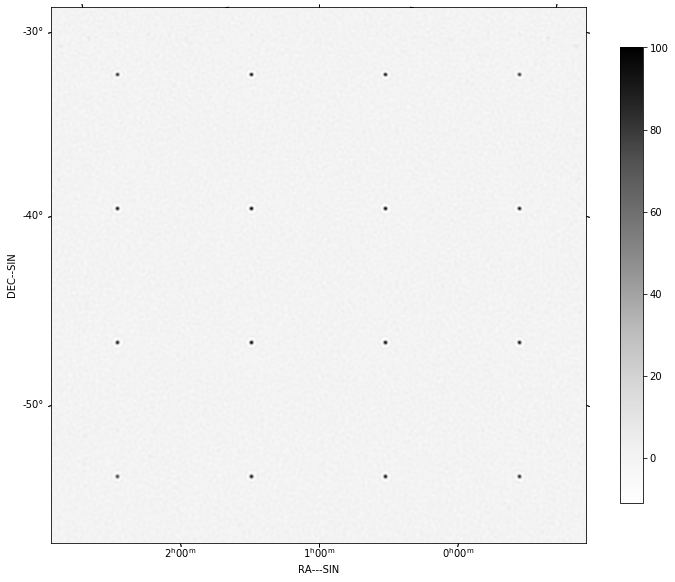

In [17]:
vt = copy_visibility(vt_original)

dirtyWProjectionWStack = create_image_from_visibility(vt, npixel=512, cellsize=0.001, npol=1)

gcfcf = create_awterm_convolutionfunction(model, nw=11, wstep=800.0/101, oversampling=8, 
                                                    support=60,
                                                    use_aaf=True)
    
future = invert_list_rsexecute_workflow([vt], [dirtyWProjectionWStack], context='wstack', 
                                        gcfcf=[gcfcf], vis_slices=11)

dirtyWProjectionWStack, sumwt = rsexecute.compute(future, sync=True)[0]

if doplot:
    show_image(dirtyWProjectionWStack)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirtyWProjectionWStack.data.max(), 
                                                             dirtyWProjectionWStack.data.min(), sumwt))
export_image_to_fits(dirtyWProjectionWStack, '%s/imaging-wterm_dirty_WProjectionWStack.fits' % (results_dir))

